# Classification Evaluation

## Libraries

In [ ]:
!pip install boruta
!pip install graphviz
!pip install pydotplus
!pip install dtreeviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 56 kB 2.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 61 kB 187 kB/s 
  Created wheel for dtreeviz: filename=dtreeviz-1.3.6-py3-none-any.whl size=67326 sha256=28b1b223d53ea792350c5f04180ddf036ead55e2b0c6d4d29135449262f57fb5
  Stored in directory: /root/.cache/pip/wheels/33/76/fe/99227ff871766e7284bb88d3d28e2f4886b8ec04d669033478
Successfully built dtreeviz


In [ ]:
# python
from typing import Tuple

# wrangling
import pandas as pd
import numpy as np

# visualization
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import binarize
from sklearn.decomposition import PCA

# evaluation
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer
from sklearn import metrics

# models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor

# models - Classifiers
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC  

# feature engineering
from boruta import BorutaPy

## Settings

In [ ]:
# Pandas
pd.set_option('display.max_columns', None)

## Functions
Move later to a utils.py

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

def evaluate_threshold(threshold:np.ndarray) -> Tuple[int, ...]:
    """
    Receives threshold, returns (sensitivity, specificity)
    """
    return (tpr[thresholds > threshold][-1], 1 - fpr[thresholds > threshold][-1])

# TRANSFORMER FOR SPECIFIC
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self._feature_names = feature_names 
    def fit(self, X, y = None):
        return self
    def transform(self, X, y = None):
        return X[self._feature_names]

# NUMERIC
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# CATEGORICAL ONE
categorical_transformer1 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# CATEGORICAL TWO
categorical_transformer2 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])


# HOW TO USE THIS CLASS
features_preprocessor = ColumnTransformer(
    transformers=[  ('numeric',  numeric_transformer, ['col1','col2']),
                    ('categorical_one', categorical_transformer1, ['col3', 'col4']),
                    ('categorical_two', categorical_transformer2, ['col5'])
    ], remainder='passthrough')

## Classes

In [ ]:
class MLmodel:
    def __init__(self, name="", accuracy=0, precision=0, recall=0, f1=0):
        self.name = name
        self.accuracy = accuracy
        self.precision = precision
        self.recall = recall
        self.f1 = f1
    def to_dict(self):
        return {
            'name': self.name,
            'accuracy': self.accuracy,
            'precision': self.precision,
            'recall': self.recall,
            'f1': self.f1     
        }    

## Objective

We'll compare two models to predict wheter certain values classify as True Cancer o False Cancer. The dataset is available through scikit learn, if you want more info of the dataset check [here](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html)

## Data

In [ ]:
from sklearn.datasets import load_breast_cancer
df = load_breast_cancer(as_frame=True).frame

In [ ]:
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


## Feature Selection
Feature Selection algorithm based on shadow features and binomial distribution

In [ ]:
X =  df.drop(labels = "target", axis = 1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [ ]:
estimator = RandomForestRegressor()

In [ ]:
boruta = BorutaPy(estimator = estimator, n_estimators = 'auto', max_iter = 100)
boruta.fit(np.array(X_train), np.array(y_train))

BorutaPy(estimator=RandomForestRegressor(n_estimators=48,
                                         random_state=RandomState(MT19937) at 0x7FB6F9F76D10),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7FB6F9F76D10)

In [ ]:
# Important features
important = list(X.columns[boruta.support_])
print(f"Features confirmed as important:   {important}")

# Other features
print(f"\nUnconfirmed features (tentative):  {list(X.columns[boruta.support_weak_])}")
print(f"\nFeatures confirmed as unimportant: {list(X.columns[~(boruta.support_ | boruta.support_weak_)])}")

Features confirmed as important:   ['mean texture', 'mean concave points', 'area error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst concavity', 'worst concave points']

Unconfirmed features (tentative):  ['worst compactness', 'worst symmetry']

Features confirmed as unimportant: ['mean radius', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst fractal dimension']


In [ ]:
X_train = X_train[important]
X_test = X_test[important]

## Feature Engineering

In [ ]:
# Train Data
scaler = StandardScaler().fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns = X_train.columns)

# Test Data
scaler = StandardScaler().fit(X_test)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

[0.60540039 0.15939745]


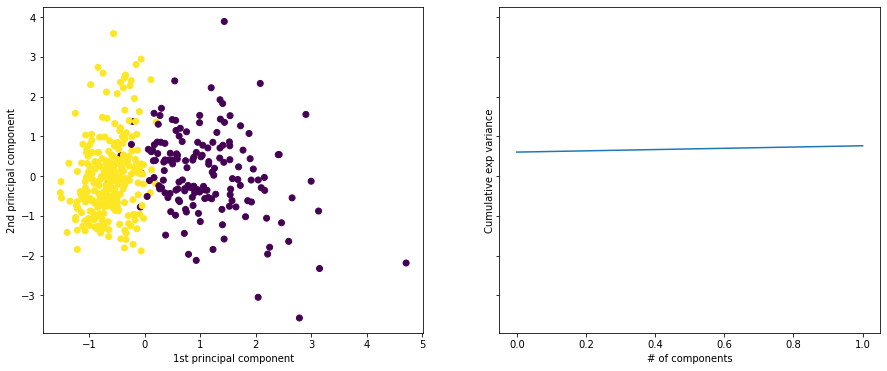

In [ ]:
# PCA
pca = PCA(n_components=2, whiten=True)
X_pca = pca.fit_transform(X_train)
y_pca = y_train.values.reshape(-1, 1)

X_test_pca = pca.transform(X_test)
y_test_pca = y_test.values.reshape(-1, 1)

# Show my two components
f, ax = plt.subplots(1, 2, sharey=True, figsize = (15, 6))
ax[0].scatter(X_pca[:, 0], X_pca[:, 1], c= y_pca[:, 0])
ax[0].set_xlabel('1st principal component')
ax[0].set_ylabel('2nd principal component')

#Variance
ax[1].plot(np.cumsum(pca.explained_variance_ratio_))
ax[1].set_xlabel('# of components')
ax[1].set_ylabel('Cumulative exp variance')

print(pca.explained_variance_ratio_)

## Clasificadores

**K-Nearest Neighbors (K-NN)**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_pca, y_pca.ravel())
y_pred = model.predict(X_test_pca)

# Confusion Matrix
confusion_matrix = metrics.confusion_matrix(y_test_pca, y_pred)
confusion_matrix

array([[50,  3],
       [ 2, 88]])

In [ ]:
accuracy = metrics.accuracy_score(y_test_pca, y_pred)*100
print('Accuracy: ' + str(round(accuracy, 2)) + ' %')

Accuracy: 96.5 %


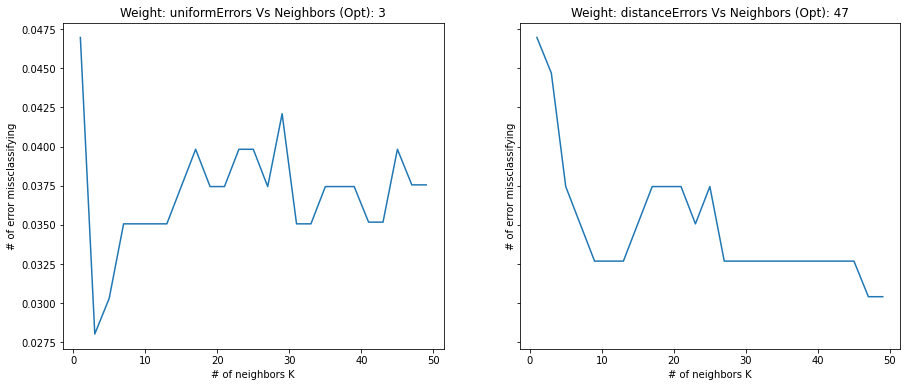

In [ ]:
col = 0
opt_weight_dic = {}
f, ax = plt.subplots(1, 2, sharey=True, figsize=(15, 6))
for weights in ['uniform', 'distance']:
    cv_scores = []
    neighbors = list(range(1,50,2))

    # 20 Fold Cross Vlaidation
    for k in neighbors:
        knn = KNeighborsClassifier(n_neighbors = k, weights = weights)
        scores = cross_val_score(knn, X_pca, y_pca.ravel(), cv=20, scoring='accuracy')
        cv_scores.append(scores.mean())

    # Finding Best K
    mse = [1 - x for x in cv_scores]
    opt_k = neighbors[mse.index(min(mse))]
    opt_weight_dic[weights] = opt_k

    # Plot
    ax[col].plot(neighbors, mse)
    ax[col].set_xlabel("# of neighbors K")
    ax[col].set_ylabel("# of error missclassifying")
    ax[col].set_title("Weight: " + str(weights) + "Errors Vs Neighbors (Opt): "+ str(opt_k))
    col += 1
f.show()  

uniform : 
 [[50  3]
 [ 2 88]]
Accuracy: 96.5034965035 % 



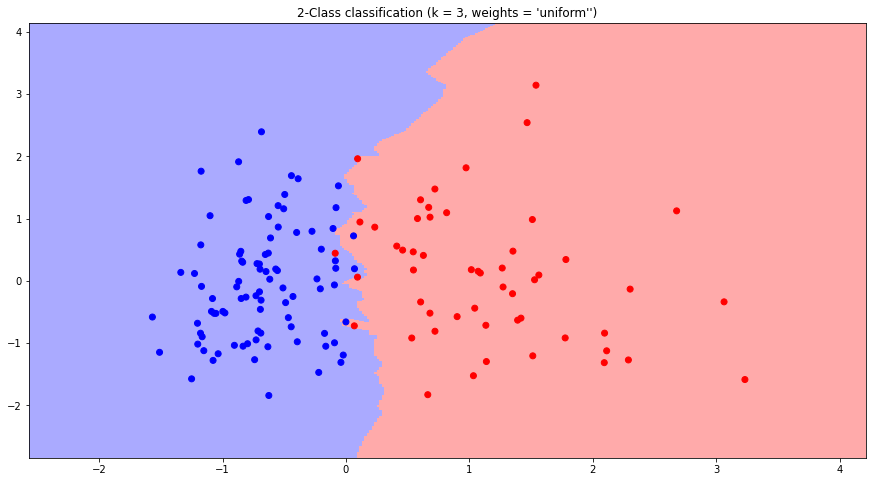

distance : 
 [[49  4]
 [ 1 89]]
Accuracy: 96.5034965035 % 



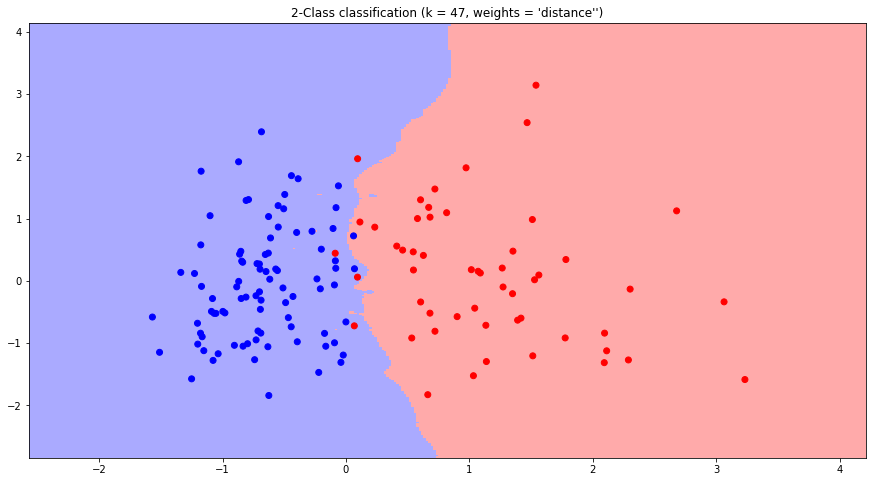

In [ ]:
# Mesh step size
h = .02

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

for weights in ['uniform', 'distance']:   
    model = KNeighborsClassifier(n_neighbors= opt_weight_dic[weights], weights = weights)
    model.fit(X_pca, y_pca.ravel())
    y_pred = model.predict(X_test_pca)
    
    # Confusion Matrix
    confusion_matrix = metrics.confusion_matrix(y_test_pca, y_pred)
    print(weights, ': \n', confusion_matrix)

    # Accuracy
    accuracy = metrics.accuracy_score(y_test_pca, y_pred)*100
    print('Accuracy: ' + str(round(accuracy, 10)) + ' % \n')

    # Visualising the Training set results
    x_min, x_max = X_test_pca[:, 0].min() - 1, X_test_pca[:, 0].max() + 1
    y_min, y_max = X_test_pca[:, 1].min() - 1, X_test_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(figsize = (15, 8))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test_pca, cmap=cmap_bold)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f"{len(y.unique())}-Class classification (k = {opt_weight_dic[weights]}, weights = '{weights}'')")
    plt.show()
    plt.close()

**Gaussian Naive-Bayes**

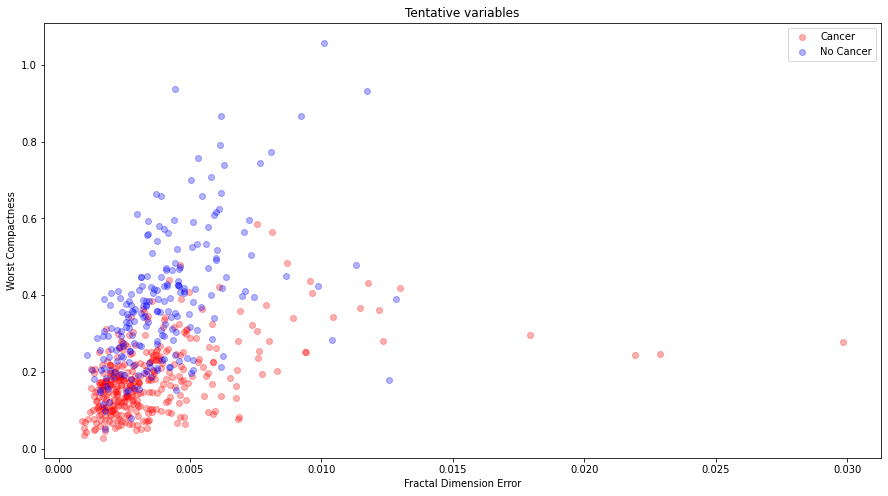

In [ ]:
yes = df[df.target == 1]
no = df[df.target == 0]

plt.figure(figsize = (15, 8))
plt.title("Tentative variables")
plt.xlabel("Fractal Dimension Error")
plt.ylabel("Worst Compactness")
plt.scatter(yes['fractal dimension error'], yes['worst compactness'], color = "red", label = "Cancer", alpha = 0.3)
plt.scatter(no['fractal dimension error'], no['worst compactness'], color = "blue", label = "No Cancer", alpha = 0.3)
plt.legend()
plt.show()

In [ ]:
model = GaussianNB()
cv_scores = cross_val_score(model, X_pca, y_pca.ravel(), cv=3)

y_pred = model.fit(X_pca, y_pca.ravel()).predict(X_test_pca)
y_pred_train = model.fit(X_pca, y_pca.ravel()).predict(X_pca)
y_pred_test = model.predict(X_test_pca)
print('Mean Accuracy: ', round(cv_scores.mean()*100, 2), '%')
print('Std Dev:       ', round(cv_scores.var()*100, 2),'%')
print(f"Out of {X_test_pca.shape[0]} labels done, {(y_test_pca.ravel() != y_pred).sum()} Errors")

# Accuray Score - Train
accuracy = metrics.accuracy_score(y_pca.ravel(), y_pred_train)
print('Accuracy Score - Train: ', accuracy)
# Accuray Score - Test
accuracy = metrics.accuracy_score(y_test_pca.ravel(), y_pred_test)
print('Accuracy Score - Test:  ', accuracy)

Mean Accuracy:  96.71 %
Std Dev:        0.05 %
Out of 143 labels done, 2 Errors
Accuracy Score - Train:  0.971830985915493
Accuracy Score - Test:   0.986013986013986


In [ ]:
cv_method = RepeatedStratifiedKFold(n_splits=12,  
                                    n_repeats=9, 
                                    random_state=0)
params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
model_CV = GridSearchCV(estimator=model, 
                        param_grid=params_NB, 
                        cv=cv_method,
                        verbose=0, 
                        scoring='accuracy')

Data_transformed = PowerTransformer().fit_transform(X_pca)
model_CV.fit(Data_transformed, y_pca.ravel())
# Accuracy Score - Train:  
predict_train = model_CV.predict(Data_transformed)
print('Accuracy Score - Train:  ', metrics.accuracy_score(y_pca.ravel(), predict_train))

Data_transformed = PowerTransformer().fit_transform(X_test_pca)
# Accuracy Score - Test:  
predict_test = model_CV.predict(Data_transformed)
print('Accuracy Score - Test:  ', metrics.accuracy_score(y_test_pca.ravel(), predict_test))

Accuracy Score - Train:   0.9694835680751174
Accuracy Score - Test:   0.9790209790209791


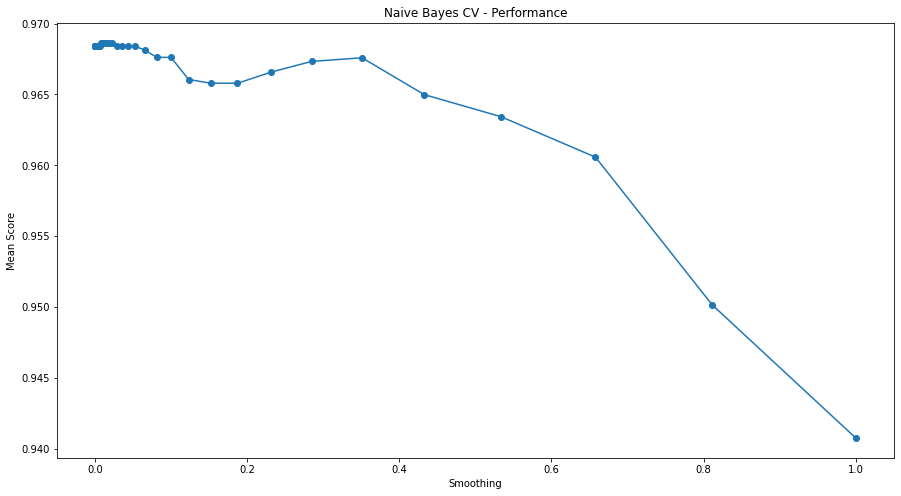

In [ ]:
results = pd.DataFrame(model_CV.cv_results_['params'])
results['test_score'] = model_CV.cv_results_['mean_test_score']

plt.figure(figsize = (15, 8))
plt.plot(results['var_smoothing'], results['test_score'], marker = 'o')    
plt.xlabel('Smoothing')
plt.ylabel("Mean Score")
plt.title("Naive Bayes CV - Performance")
plt.show()

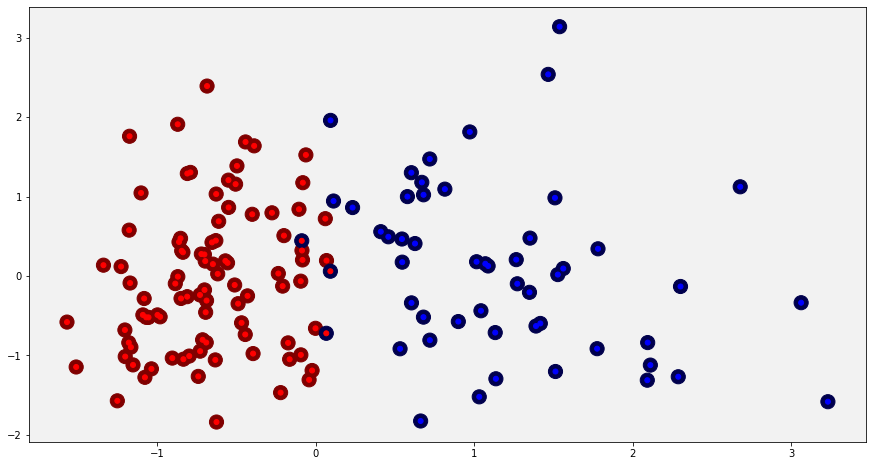

In [ ]:
plt.figure(figsize = (15, 8))
# Test Data - Big 
plt.scatter(X_test_pca[:, 0], 
            X_test_pca[:, 1],
            c=y_test_pca, s=200, cmap='seismic')
lim = plt.axis()
# Predictions - Smaller
plt.scatter(X_test_pca[:, 0], 
            X_test_pca[:, 1],
            c=predict_test, s=25, cmap='bwr', alpha=1)
plt.axis(lim)

# LAYOUT
ax = plt.gca()
ax.set_facecolor((0, 0, 0, .05))

**SVM**

In [ ]:
# BASELINE
model = SVC(kernel='linear')
model.fit(X_pca, y_pca.ravel())
y_pred = model.predict(X_test_pca)
print(metrics.accuracy_score(y_test_pca.ravel(), y_pred))

0.986013986013986


In [ ]:
# BALANCED ? or NOT?
from collections import Counter
print('Value Count %s' % Counter(y_pca.ravel()))

Value Count Counter({1: 267, 0: 159})


In [ ]:
# UPSAMPLING
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state = 42)
X_train_up, y_train_up = sm.fit_resample(X_pca, y_pca)
print('UpSample %s' % Counter(y_train_up))

UpSample Counter({1: 267, 0: 267})


In [ ]:
# UPSAMPLE SVM
model = SVC(kernel='linear')
model.fit(X_train_up, y_train_up.ravel())
y_pred = model.predict(X_test_pca)
print(metrics.accuracy_score(y_test_pca.ravel(), y_pred))

0.9790209790209791


In [ ]:
# DOWNSAMPLING
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler()
X_train_down, y_train_down = rus.fit_resample(X_pca, y_pca)
print('DownSample %s' % Counter(y_train_down))

DownSample Counter({0: 159, 1: 159})


In [ ]:
# DOWNSAMPLE SVM
model = SVC(kernel='linear')
model.fit(X_train_down, y_train_down.ravel())
y_pred = model.predict(X_test_pca)
print(metrics.accuracy_score(y_test_pca.ravel(), y_pred))

0.9790209790209791


In [ ]:
# GRIDSEARCH
model = SVC()
param_grid = [{'kernel':['poly', 'rbf', 'sigmoid','linear'],
               'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                'C':    [0.1, 1, 10, 100, 1000] }]

gsv = GridSearchCV(model, param_grid, cv=3, n_jobs=10, refit=True, verbose=2, scoring='accuracy', error_score=0)
gsv.fit(X_pca, y_pca.ravel())

print(gsv.best_estimator_)
y_pred = gsv.best_estimator_.predict(X_test_pca)
print(metrics.accuracy_score(y_test_pca.ravel(), y_pred))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
SVC(C=10, gamma=0.01)
0.972027972027972


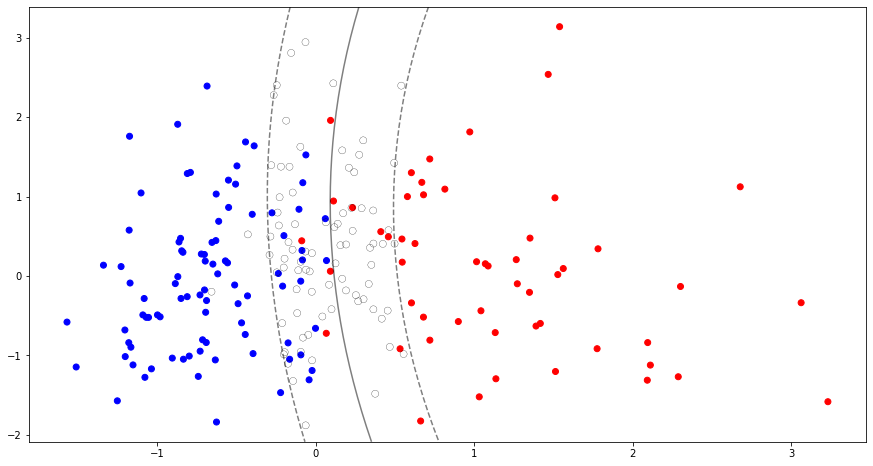

In [ ]:
plt.figure(figsize = (15, 8))
# COLORS
cmap_bold = ListedColormap(['#FF0000', 
                            '#00FF00', 
                            '#0000FF'])
plt.scatter(X_test_pca[:, 0], 
            X_test_pca[:, 1], 
            c = y_test_pca,
            cmap = cmap_bold)

# CANVAS
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# GRID
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = gsv.decision_function(xy).reshape(XX.shape)

# DECISION BOUNDARIES and MARGINS
ax.contour( XX, 
            YY, 
            Z, 
            colors="k", 
            levels=[-1, 0, 1], 
            alpha=0.5, 
            linestyles=["--", "-", "--"])

# SUPPORT VECTORS
ax.scatter(
    gsv.best_estimator_.support_vectors_[:, 0],
    gsv.best_estimator_.support_vectors_[:, 1],
    s=50,
    linewidth=.25,
    facecolors="none",
    edgecolors="k",)
plt.show()

**Logistic Regression**

In [ ]:
# BASELINE
model = LogisticRegression()
model.fit(X_pca, y_pca.ravel())
y_pred = model.predict(X_test_pca)

accuracy = metrics.accuracy_score(y_test_pca.ravel(), y_pred)
print(accuracy)

confusion_matrix = metrics.confusion_matrix(y_test_pca.ravel(), y_pred)
print(confusion_matrix)

0.9790209790209791
[[50  3]
 [ 0 90]]


In [ ]:
# GRIDSEARCH
from sklearn.calibration import CalibratedClassifierCV
model = LogisticRegression()
param_grid = [{'solver': ['newton-cg', 'lbfgs', 'liblinear'],
               'penalty': ['l2'],
               'C':    [0.1, 1, 10, 100, 1000] }]
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=6, random_state=1)
gsv = GridSearchCV(model, 
                   param_grid, 
                   cv=cv, 
                   n_jobs=-1, 
                   refit=True, 
                   verbose=0, 
                   scoring='accuracy', 
                   error_score=0)
calibrated_clf = CalibratedClassifierCV(
    base_estimator = gsv,
    cv=3, 
    method='sigmoid')
calibrated_clf.fit(X_pca, y_pca.ravel())

CalibratedClassifierCV(base_estimator=GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=6, n_splits=10, random_state=1),
                                                   error_score=0,
                                                   estimator=LogisticRegression(),
                                                   n_jobs=-1,
                                                   param_grid=[{'C': [0.1, 1,
                                                                      10, 100,
                                                                      1000],
                                                                'penalty': ['l2'],
                                                                'solver': ['newton-cg',
                                                                           'lbfgs',
                                                                           'liblinear']}],
                                                   scoring='accuracy'),
                

In [ ]:
y_pred = calibrated_clf.predict(X_test_pca)
print(metrics.accuracy_score(y_test_pca.ravel(), y_pred))

0.9790209790209791


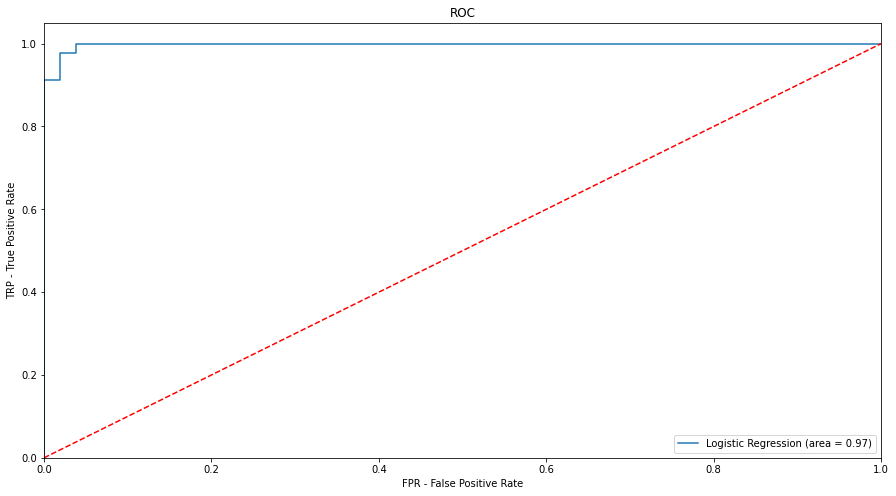

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

plt.figure(figsize = (15, 8))
# ROC and AUC
logit_roc_auc = roc_auc_score(y_test_pca, 
                              calibrated_clf.predict(X_test_pca))
fpr, tpr, thresholds = roc_curve(y_test_pca, 
                                 calibrated_clf.predict_proba(X_test_pca)[:,1])

# DATA
plt.plot(fpr, 
         tpr, 
         label=f'Logistic Regression (area = {round(logit_roc_auc,2)})')
plt.plot([0, 1], [0, 1],'r--')

# LAYOUT
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR - False Positive Rate')
plt.ylabel('TRP - True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")

plt.show()

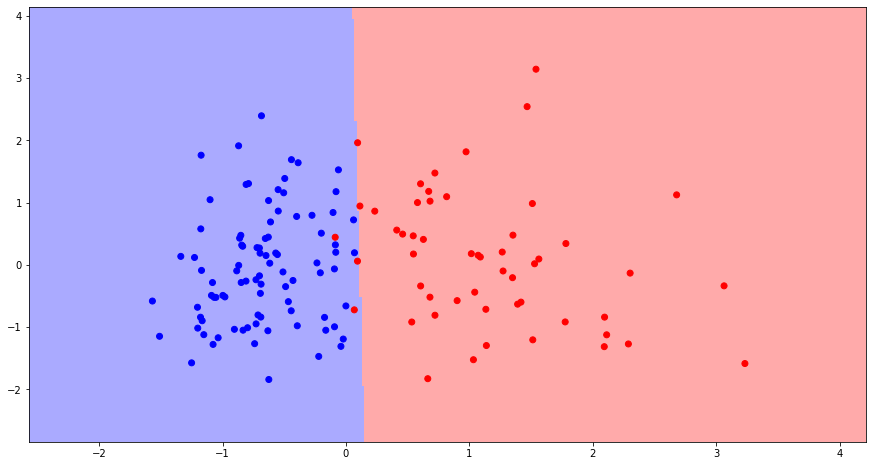

In [ ]:
# Mesh step size
h = .02

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

# Visualising the Training set results
x_min, x_max = X_test_pca[:, 0].min() - 1, X_test_pca[:, 0].max() + 1
y_min, y_max = X_test_pca[:, 1].min() - 1, X_test_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))
Z = calibrated_clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize = (15, 8))
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Test Data
cmap_bold = ListedColormap(['#FF0000', 
                            '#00FF00', 
                            '#0000FF'])
plt.scatter(X_test_pca[:, 0], 
            X_test_pca[:, 1], 
            c = y_test_pca,
            cmap = cmap_bold)

**Decision Tree**

In [ ]:
model = DecisionTreeClassifier(max_depth =3, random_state = 42)
model.fit(X_pca, y_pca.ravel())
y_pred = model.predict(X_test_pca)
confusion_matrix = metrics.confusion_matrix(y_test_pca,y_pred)
confusion_matrix

array([[52,  1],
       [ 2, 88]])

In [ ]:
print(metrics.classification_report(y_test_pca,y_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97        53
           1       0.99      0.98      0.98        90

    accuracy                           0.98       143
   macro avg       0.98      0.98      0.98       143
weighted avg       0.98      0.98      0.98       143



In [ ]:
import numpy as np
importance = pd.DataFrame({'feature': ["1st","2nd"], 'importance' : np.round(model.feature_importances_, 3)})
importance.sort_values('importance', ascending=False, inplace = True)
print(importance)

  feature  importance
0     1st         1.0
1     2nd         0.0


In [ ]:
from sklearn.model_selection import GridSearchCV

model = DecisionTreeClassifier(max_depth =3, random_state = 0)
params = {'max_depth': range(1,10), 
          'min_samples_leaf' : range(1,10),
          'min_samples_split': [2, 3] + np.arange(0.1, 0.9, 0.1).tolist(),
          'criterion' : ['gini', 'entropy']
        }
scores = ['recall', 'precision', 'f1']
for score in scores:
    print(f"Tuning for {score}")    
    clf = GridSearchCV(
        model, params,
        cv = 10,
        n_jobs = -1, 
        scoring = f'{score}_macro',
        verbose = 0,
        refit = True)
    clf.fit(X_pca, y_pca.ravel())
    print(clf.best_params_)
    print(clf.best_score_, '\n\n')
    model =  clf.best_estimator_

print("FINAL")
print(clf.best_params_)
print(clf.best_score_)

Tuning for recall
{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 6, 'min_samples_split': 2}
0.9657407407407408 


Tuning for precision
{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 6, 'min_samples_split': 2}
0.9704646739332338 


Tuning for f1
{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 6, 'min_samples_split': 2}
0.9675196952570658 


FINAL
{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 6, 'min_samples_split': 2}
0.9675196952570658


In [ ]:
print(metrics.classification_report(y_test_pca,model.predict(X_test_pca)))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97        53
           1       0.99      0.98      0.98        90

    accuracy                           0.98       143
   macro avg       0.98      0.98      0.98       143
weighted avg       0.98      0.98      0.98       143



In [ ]:
print(metrics.confusion_matrix(y_test_pca, clf.predict(X_test_pca)))

[[52  1]
 [ 2 88]]


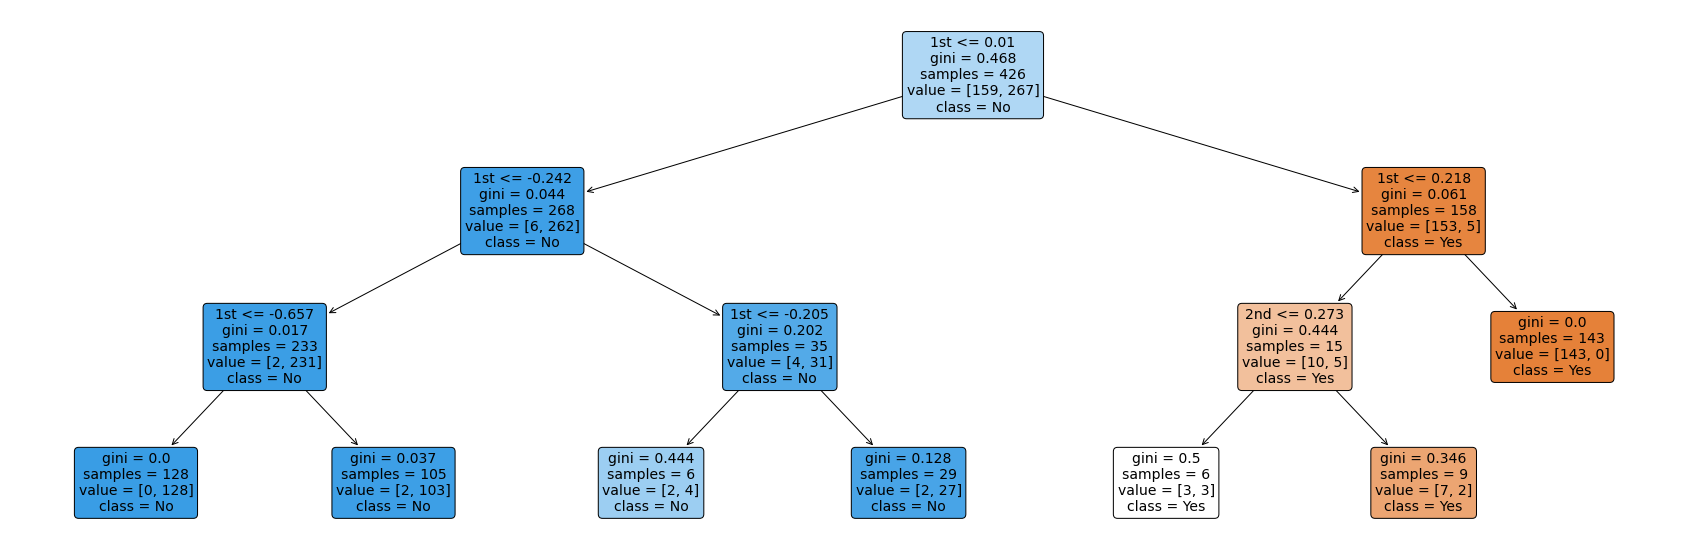

In [ ]:
from sklearn.tree import plot_tree
plt.figure(figsize=(30,10))
plot_tree(model,
          #use the feature names stored
          feature_names = ["1st", "2nd"],
          #use the class names stored
          class_names = ["Yes", "No"],
          rounded = True,
          filled = True,
          fontsize=14)
plt.show()

In [39]:
from sklearn.tree import export_text, export_graphviz
text_representation = export_text(model)
print(text_representation)

|--- feature_0 <= 0.01
|   |--- feature_0 <= -0.24
|   |   |--- feature_0 <= -0.66
|   |   |   |--- class: 1
|   |   |--- feature_0 >  -0.66
|   |   |   |--- class: 1
|   |--- feature_0 >  -0.24
|   |   |--- feature_0 <= -0.21
|   |   |   |--- class: 1
|   |   |--- feature_0 >  -0.21
|   |   |   |--- class: 1
|--- feature_0 >  0.01
|   |--- feature_0 <= 0.22
|   |   |--- feature_1 <= 0.27
|   |   |   |--- class: 0
|   |   |--- feature_1 >  0.27
|   |   |   |--- class: 0
|   |--- feature_0 >  0.22
|   |   |--- class: 0



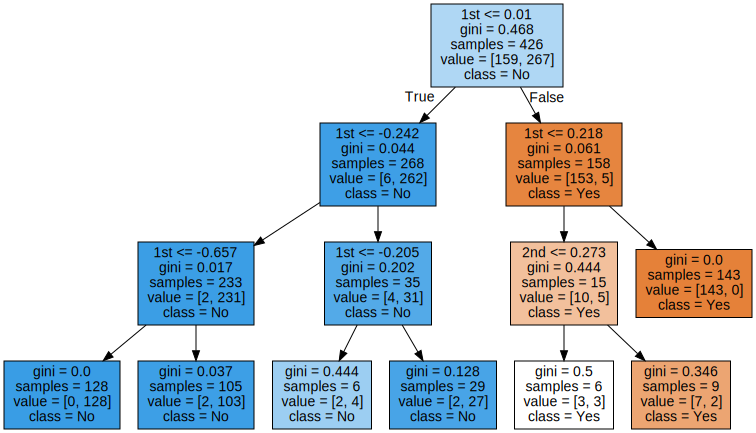

In [40]:
import graphviz
dot_data = export_graphviz(model, out_file=None, 
                                feature_names=["1st", "2nd"],  
                                class_names=["Yes", "No"],
                                filled=True)
graph = graphviz.Source(dot_data, format="png") 
graph

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


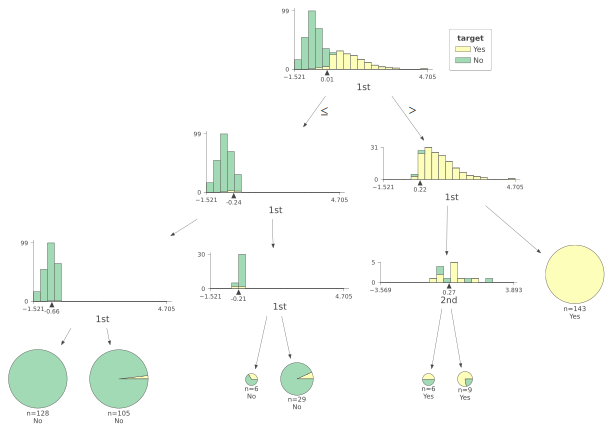

In [42]:
from dtreeviz.trees import dtreeviz # remember to load the package

viz = dtreeviz(model, X_pca, y_pca.ravel(),
                target_name="target",
                feature_names=["1st", "2nd"],
                class_names=list(["Yes", "No"]))

viz

**Algorithm Ensamble**

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# INSTANCING THE MODELS
classifiers = [
    LogisticRegression(random_state=0), 
    KNeighborsClassifier(), 
    RandomForestClassifier(random_state=0)
]

# PARAMETERS PER MODEL
logregress_parameters = {
    'classifier__penalty' : ['l1','l2'],     
    'classifier__C'       : np.logspace(-3,3,7),
    'classifier__solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}
knn_parameters = {
    'classifier__n_neighbors': np.arange(1, 25, 2)
}
randomforest_parameters = {
    'classifier__n_estimators': [50, 100, 200, 300]
}

# GROUPING FOR GridSearchCV
parameters = [
    logregress_parameters, 
    knn_parameters, 
    randomforest_parameters
]

estimators = []
for i, classifier in enumerate(classifiers):
    # create a Pipeline object
    pipe = Pipeline(steps=[
        #('preprocessor', features_preprocessor), not needed right now
        ('classifier', classifier)
    ])
    clf = GridSearchCV(pipe,              
              param_grid = parameters[i], 
              scoring='accuracy',         
              cv=10)                      
    clf.fit(X_pca, y_pca.ravel())
    print("Tuned Hyperparameters :", clf.best_params_)
    print("Accuracy :", clf.best_score_)
    # CLF to estimators
    estimators.append((classifier.__class__.__name__, clf))

Tuned Hyperparameters : {'classifier__C': 0.01, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Accuracy : 0.9744186046511627
Tuned Hyperparameters : {'classifier__n_neighbors': 5}
Accuracy : 0.9697120708748616
Tuned Hyperparameters : {'classifier__n_estimators': 50}
Accuracy : 0.969767441860465


In [ ]:
from sklearn.ensemble import VotingClassifier

ensemble = VotingClassifier(estimators, voting='hard')
ensemble.fit(X_pca, y_pca.ravel())
ensemble.score(X_test_pca, y_test_pca)

0.9790209790209791

In [ ]:
ensemble = VotingClassifier(estimators, voting='soft')
ensemble.fit(X_pca, y_pca.ravel())
ensemble.score(X_test_pca, y_test_pca)

0.9790209790209791

In [ ]:
ensemble = VotingClassifier(estimators, 
                            voting='soft', 
                            weights=[1,1,1])
ensemble.fit(X_pca, y_pca.ravel())
ensemble.score(X_test_pca, y_test_pca)

0.9790209790209791

**Neural Networks**

In [ ]:
from sklearn.neural_network import MLPClassifier

features_n = 2
labels_n = 2

input_layer_size = features_n             # Dimensionality
hidden_layer_size = input_layer_size*2    # Hidden Layer
output_layer_size = labels_n              # Number of Labels
layers = (input_layer_size, hidden_layer_size, output_layer_size)

mlp = MLPClassifier(hidden_layer_sizes=layers, 
                    activation='relu', 
                    solver='sgd',  #adam
                    max_iter=1000000,
                    alpha=1e-4,
                    random_state=1,
                    learning_rate_init=0.1)
mlp.fit(X_pca, y_pca.ravel())

predict_train = mlp.predict(X_pca)
predict_test = mlp.predict(X_test_pca)

In [ ]:
print(metrics.confusion_matrix( y_pca.ravel(), predict_train))
print(metrics.classification_report( y_pca.ravel(), predict_train))

[[153   6]
 [  5 262]]
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       159
           1       0.98      0.98      0.98       267

    accuracy                           0.97       426
   macro avg       0.97      0.97      0.97       426
weighted avg       0.97      0.97      0.97       426



In [ ]:
print(metrics.confusion_matrix( y_test_pca.ravel(), predict_test))
print(metrics.classification_report( y_test_pca.ravel(), predict_test))

[[52  1]
 [ 2 88]]
              precision    recall  f1-score   support

           0       0.96      0.98      0.97        53
           1       0.99      0.98      0.98        90

    accuracy                           0.98       143
   macro avg       0.98      0.98      0.98       143
weighted avg       0.98      0.98      0.98       143



In [ ]:
from sklearn.model_selection import RandomizedSearchCV

def hyperparameter_tune(clf, parameters, iterations, X, y):
  randomSearch = RandomizedSearchCV(clf, param_distributions=parameters, n_jobs=-1, n_iter=iterations, cv=5) 
  randomSearch.fit(X,y)
  params = randomSearch.best_params_
  score = randomSearch.best_score_
  return params, score, randomSearch.best_estimator_


parameters = {
    'solver': ['sgd', 'adam', 'lbfgs'],
    'activation': ['relu', 'tanh'],
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'alpha': [0.3, 0.2, 0.1, 0.01, 0.001, 0.0001],
    'learning_rate': ['constant','adaptive']}

clf = MLPClassifier(batch_size=32, verbose=True, early_stopping=True, max_iter=100)

parameters_after_tuning, score_after_tuning, clf = hyperparameter_tune(clf, 
                                                                  parameters, 
                                                                  20, 
                                                                  X_pca, 
                                                                  y_pca.ravel());
print(score_after_tuning)
clf.fit(X_pca,  y_pca.ravel())

predict_train = mlp.predict(X_pca)
predict_test = mlp.predict(X_test_pca)

0.9765800273597811


In [ ]:
print(metrics.confusion_matrix( y_pca.ravel(), predict_train))
print(metrics.classification_report( y_pca.ravel(), predict_train))

[[153   6]
 [  5 262]]
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       159
           1       0.98      0.98      0.98       267

    accuracy                           0.97       426
   macro avg       0.97      0.97      0.97       426
weighted avg       0.97      0.97      0.97       426



In [ ]:
print(metrics.confusion_matrix( y_test_pca.ravel(), predict_test))
print(metrics.classification_report( y_test_pca.ravel(), predict_test))

[[52  1]
 [ 2 88]]
              precision    recall  f1-score   support

           0       0.96      0.98      0.97        53
           1       0.99      0.98      0.98        90

    accuracy                           0.98       143
   macro avg       0.98      0.98      0.98       143
weighted avg       0.98      0.98      0.98       143



**Resultados**

Ya con optimizaciones la mayoría obtuvo un performance muy similar entre sí. El único que no pudo seguir el paso fue el Decision Tree Classifier

## Model Comparison

### Model 1 - RandomForest

#### Fit

In [ ]:
clf = RandomForestClassifier(n_estimators = 500, max_depth = 4, max_features = 3, bootstrap = True, random_state = 18).fit(X_train, y_train)
y_pred_class = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)[:, 1]

#### Metrics

In [ ]:
confusion = metrics.confusion_matrix(y_test, y_pred_class)
confusion

array([[52,  1],
       [ 4, 86]])

In [ ]:
print('Scikit Calculated Accuracy = ' , round(metrics.accuracy_score(y_test, y_pred_class), 5))
print('Scikit Calculated Precision = ' , round(metrics.precision_score(y_test, y_pred_class),5))
print('Scikit Calculated Sensitivity = ' , round(metrics.recall_score(y_test, y_pred_class),5))
print('Scikit Calculated AUC = ' ,metrics.roc_auc_score(y_test, y_pred_prob))

Scikit Calculated Accuracy =  0.96503
Scikit Calculated Precision =  0.98851
Scikit Calculated Sensitivity =  0.95556
Scikit Calculated AUC =  0.9985324947589098


### Model 2 - Logistic Regression

#### Fit

In [ ]:
logreg = LogisticRegression(solver='lbfgs', max_iter=400).fit(X_train, y_train)
y_pred_class = logreg.predict(X_test)
y_pred_prob = logreg.predict_proba(X_test)[:, 1]

#### Metrics

In [ ]:
confusion = metrics.confusion_matrix(y_test, y_pred_class)
confusion

array([[52,  1],
       [ 1, 89]])

In [ ]:
print('Scikit Calculated Accuracy = ' , round(metrics.accuracy_score(y_test, y_pred_class), 5))
print('Scikit Calculated Precision = ' , round(metrics.precision_score(y_test, y_pred_class),5))
print('Scikit Calculated Sensitivity = ' , round(metrics.recall_score(y_test, y_pred_class),5))
print('Scikit Calculated AUC = ' ,metrics.roc_auc_score(y_test, y_pred_prob))

Scikit Calculated Accuracy =  0.98601
Scikit Calculated Precision =  0.98889
Scikit Calculated Sensitivity =  0.98889
Scikit Calculated AUC =  0.9983228511530399


### Conclusion
En Accuracy, Precision, Sensitivity gana en definitiva la regresión logística, pero es por unidades decimales. Es lo mismo para el AUC, solo que aquí ya es por las centesimas la diferencia. En otras palabras los modelos son muy similares. Todavía se podria ajustar el treshold o usar gridsearch.

## Models Iteratively Evaluate

### Models Definition

In [ ]:
models = [('KNN', KNeighborsClassifier()),
          ('SVC', SVC()),
          ('LR', LogisticRegression(max_iter=300000)),
          ('DT', DecisionTreeClassifier()),
          ('GNB', GaussianNB()),
          ('RF', RandomForestClassifier()),
          ('GB', GradientBoostingClassifier())]

### Data Definition

In [ ]:
# Stratify makes sure each class is represented in equal proportion in train and test.
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = df.target, random_state=0)

### Scores

In [ ]:
fitmodels = []
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    fitmodels.append(
        MLmodel(name,
            metrics.accuracy_score(y_test, y_pred),
            metrics.precision_score(y_test, y_pred),
            metrics.recall_score(y_test, y_pred),
            metrics.f1_score(y_test, y_pred)))
scores = pd.DataFrame.from_records([fitmodel.to_dict() for fitmodel in fitmodels])
scores

,name,accuracy,precision,recall,f1
0,KNN,0.916084,0.933333,0.933333,0.933333
1,SVC,0.916084,0.897959,0.977778,0.936170
2,LR,0.937063,0.955056,0.944444,0.949721
3,DT,0.930070,0.954545,0.933333,0.943820
4,GNB,0.923077,0.943820,0.933333,0.938547
5,RF,0.944056,0.955556,0.955556,0.955556
6,GB,0.951049,0.977011,0.944444,0.960452


###  K-Fold cross validation

In [ ]:
fitmodels_k = []
for name, model in models: 
    kfold = KFold(n_splits=10, random_state=10, shuffle=True) 
    results = cross_validate(model, X, y, cv = kfold, scoring = ['accuracy', 'precision','recall','f1'])
    fitmodels_k.append( MLmodel(name,
                              np.mean(results['test_accuracy']),
                              np.mean(results['test_precision']),
                              np.mean(results['test_recall']),
                              np.mean(results['test_f1'])))    
kval = pd.DataFrame.from_records([fitmodel.to_dict() for fitmodel in fitmodels_k])
kval

,name,accuracy,precision,recall,f1
0,KNN,0.934900,0.932986,0.963338,0.947680
1,SVC,0.917231,0.893295,0.983230,0.935392
2,LR,0.952475,0.955894,0.969264,0.961310
3,DT,0.917325,0.933615,0.935270,0.932394
4,GNB,0.940163,0.940503,0.966648,0.951533
5,RF,0.955952,0.959398,0.967537,0.963183
6,GB,0.961247,0.961852,0.974617,0.967460


**Cross Validation with several metrics**

La función de cross_validate respecto a cross_val_score, permite dictar multiples mètricas para comparar, además regresa un diccionario que trae los resultados de cada modelo. Lo que sucede en kfold es que el dataset original se divide en grupos iguales con su propio train y validation. Pero, no jala si el dataset no está balanceado.

### Visualizations

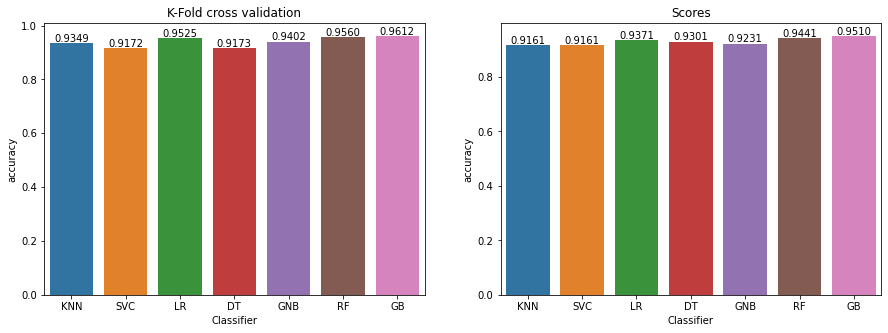

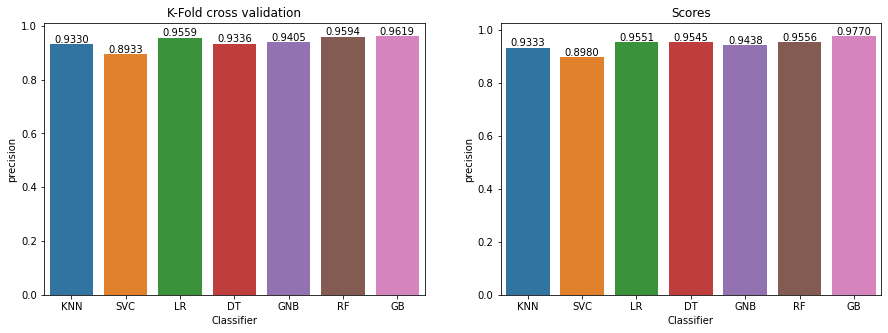

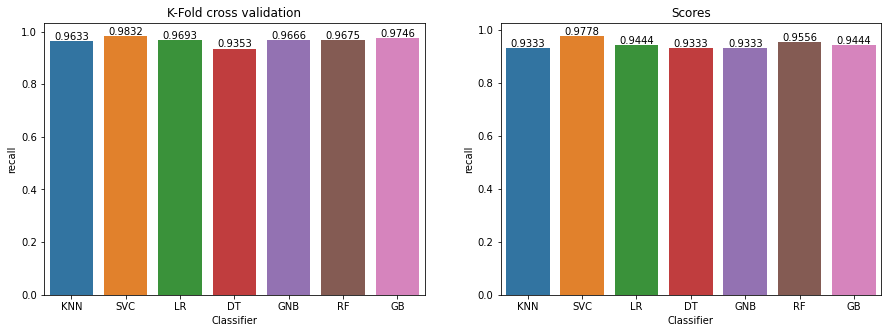

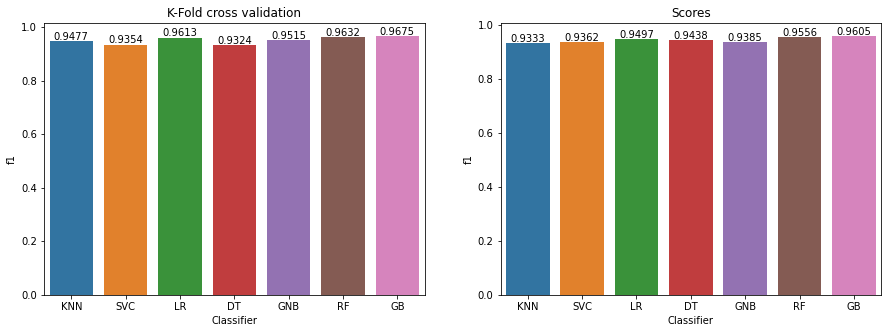

In [ ]:
for element in list(MLmodel().to_dict().keys())[1:]:
    fig, ax = plt.subplots(1, 2, figsize=(15,5))

    sns.barplot(x = kval['name'], y = kval[element], data = kval, ax=ax[0])
    ax[0].set(title = "K-Fold cross validation", xlabel='Classifier', ylabel=element)
    for p in ax[0].patches:
        height = p.get_height()
        ax[0].text(p.get_x() + p.get_width()/2, height + 0.005, '{:1.4f}'.format(height), ha="center") 

    sns.barplot(x = scores['name'], y = scores[element], data = scores, ax=ax[1])
    ax[1].set(title = "Scores", xlabel='Classifier', ylabel=element)
    for p in ax[1].patches:
        height = p.get_height()
        ax[1].text(p.get_x() + p.get_width()/2, height + 0.005, '{:1.4f}'.format(height), ha="center")     
        
    plt.show()

**CIERRE**

Lo que aprendimos aquí son las maneras en que se podría evaluar un modelo de clasificación y compararlo con otros modelos.